In [1]:
import torch
import torch.nn as nn
from torchinfo import summary

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Data augmentation
transform_train = transforms.Compose([
    transforms.RandomRotation(30),  # Randomly rotate between [-30, 30] degress
    transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.Flowers102(
    root='./dataset/Flowers102',
    split='train',
    download=True,
    transform=transform_train,
)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=6)

test_dataset = datasets.Flowers102(
    root='./dataset/Flowers102',
    split='test',
    download=True,
    transform=transform_test,
)

test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=6)

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, droput=0.5):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=droput),
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=droput),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
summary(AlexNet(), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [5]:
from torchvision import models

summary(models.alexnet(), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [6]:
import torch.optim as optim
from tqdm import *
import numpy as np
import sys

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(0)

model = AlexNet(num_classes=102).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 100
loss_history = []
acc_history = []

for epoch in tqdm(range(num_epochs), file=sys.stdout):
    total_loss = 0
    total_acc = 0
    total_correct = 0

    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        pred = model(images)
        loss = loss_fn(pred, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            total_correct += (pred.argmax(1) == labels).sum().item()

    loss_history.append(np.log10(total_loss))
    acc_history.append(total_correct / len(test_dataset))

    if epoch % 20 == 0:
        tqdm.write(f"Epoch: {epoch:>5}, Loss: {loss_history[-1].item():>7.5f}, Accuracy: {acc_history[-1]:>7.5f}")

Epoch:     0, Loss: 1.26719, Accuracy: 0.00553
Epoch:    20, Loss: 1.26709, Accuracy: 0.00829  
Epoch:    40, Loss: 1.26201, Accuracy: 0.01561  
Epoch:    60, Loss: 1.20909, Accuracy: 0.05318  
Epoch:    80, Loss: 1.16204, Accuracy: 0.08863  
100%|██████████| 100/100 [33:56<00:00, 20.37s/it]


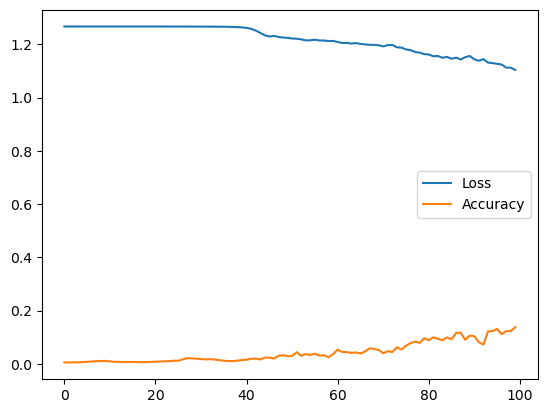

Accuracy: 0.13807


In [7]:
import matplotlib.pyplot as plt

plt.plot(loss_history, label="Loss")
plt.plot(acc_history, label="Accuracy")
plt.legend()
plt.show()

print(f"Accuracy: {acc_history[-1]:>7.5f}")